In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import sys

tf.keras.utils.set_random_seed(2022)

print("Tensorflow ",tf.__version__)
print("Numpy ", np.__version__)
print("Pandas ", pd.__version__)
print("Matplotlib ", matplotlib.__version__)
print("Python ", sys.version)

Tensorflow  2.9.1
Numpy  1.22.4
Pandas  1.4.3
Matplotlib  3.5.2
Python  3.9.13 | packaged by conda-forge | (main, May 27 2022, 17:01:00) 
[Clang 13.0.1 ]


# XOR Example of Data Free Distillation and Verification

In this notebook, we demonstrate data-free knowledge distillation and verification using an XOR dataset.

## The XOR dataset
Here is the dataset we will train with. It includes 1000 uniformly distributed samples of the quadrant function within the region (-1,1) of the $\mathbb{R}^2$ plane.

In [2]:
def dataset_xor_uniform(n=4096):
    inputs = np.random.rand(n,2)-0.5
    target = np.logical_xor(inputs[:,0]>0, inputs[:,1]>0).astype(int)
    return inputs, target.reshape((n,1))

inputs, outputs = dataset_xor_uniform()
print(inputs.shape, outputs.shape)

(4096, 2) (4096, 1)


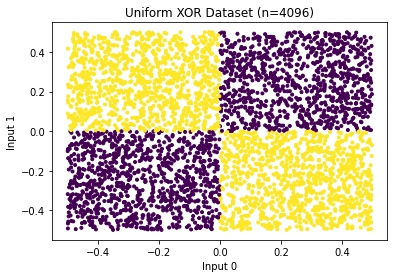

In [3]:
plt.scatter(inputs[:,0], inputs[:,1], c=outputs[:,0], marker=".")
plt.title("Uniform XOR Dataset (n=4096)")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

## Train teacher network

Now, train a fully connected neural network on this dataset with ~5,000 free parameters for 100 epochs.

In [4]:
(inputs.shape, outputs.shape)
outputs_one_hot = tf.keras.utils.to_categorical(outputs)

In [5]:
outputs, outputs_one_hot

(array([[0],
        [0],
        [1],
        ...,
        [1],
        [1],
        [1]]),
 array([[1., 0.],
        [1., 0.],
        [0., 1.],
        ...,
        [0., 1.],
        [0., 1.],
        [0., 1.]], dtype=float32))

In [6]:
num_observations = inputs.shape[0]
num_inputs = inputs.shape[1]
num_outputs = outputs_one_hot.shape[1]

hidden_layer_width=300
num_hidden_layers=6

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(num_inputs,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(num_outputs))

teacher = tf.keras.Sequential(layers)

teacher.compile(
loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
metrics=[tf.keras.metrics.CategoricalAccuracy()],
optimizer=tf.keras.optimizers.Adam(0.001),
)

teacher.summary()

teacher.fit(
    x=inputs,
    y=outputs_one_hot,
    shuffle=True,
    validation_split=.2,
    epochs=250,
    batch_size=128,
    )


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 300)               900       
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                                 
 dense_2 (Dense)             (None, 300)               90300     
                                                                 
 dense_3 (Dense)             (None, 300)               90300     
                                                                 
 dense_4 (Dense)             (None, 300)               90300     
                                                                 
 dense_5 (Dense)             (None, 300)               90300     
                                                                 
 dense_6 (Dense)             (None, 2)                 6

2022-11-04 22:34:29.818934: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


26/26 [==============================] - 1s 13ms/step - loss: 0.4133 - categorical_accuracy: 0.8095 - val_loss: 0.0712 - val_categorical_accuracy: 0.9744
Epoch 2/250
26/26 [==============================] - 0s 6ms/step - loss: 0.1188 - categorical_accuracy: 0.9594 - val_loss: 0.0598 - val_categorical_accuracy: 0.9780
Epoch 3/250
26/26 [==============================] - 0s 6ms/step - loss: 0.0538 - categorical_accuracy: 0.9765 - val_loss: 0.0615 - val_categorical_accuracy: 0.9732
Epoch 4/250
26/26 [==============================] - 0s 6ms/step - loss: 0.0463 - categorical_accuracy: 0.9817 - val_loss: 0.0329 - val_categorical_accuracy: 0.9890
Epoch 5/250
26/26 [==============================] - 0s 6ms/step - loss: 0.0445 - categorical_accuracy: 0.9829 - val_loss: 0.0834 - val_categorical_accuracy: 0.9707
Epoch 6/250
26/26 [==============================] - 0s 6ms/step - loss: 0.0496 - categorical_accuracy: 0.9795 - val_loss: 0.0321 - val_categorical_accuracy: 0.9854
Epoch 7/250
26/26 [==

313/313 [==============================] - 2s 5ms/step


/var/folders/3g/8436y4yj1r9367dvt15y6jqcdx0hcv/T/ipykernel_96190/686390113.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy,z, label="Prediction (large)")


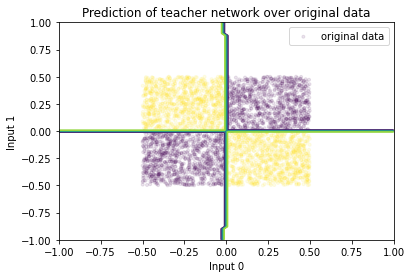

In [7]:
y_pred = teacher.predict(inputs)

X = np.linspace(-1,1,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = teacher.predict(np.c_[xx.ravel(), yy.ravel()])
labels = np.argmax(labels, axis=1)
z = labels.reshape(xx.shape)

plt.contour(xx,yy,z, label="Prediction (large)")
plt.scatter(inputs[:,0], inputs[:,1], c=outputs[:,0], marker=".", label="original data", alpha=0.1)
plt.legend()
plt.title("Prediction of teacher network over original data")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

With 20,601 trainable parameters, we are able to get a pretty good decision boundary at least for the in-sample region (-1,1). However, we can see that the network has not learned the exact XOR rule, as evidenced by some unnecessary level curves at the edges of the decision boundary. One may ask the question, does this network faithfully compute XOR throughout the entire $\mathbb{R}^2$ plane?

## Train student network using Data-Free Distillation

In [8]:
## Generate synthetic dataset using a random distribution.

synthetic_inputs = np.random.rand(4096,2)-0.5
synthetic_outputs = teacher.predict(synthetic_inputs)

128/128 [==============================] - 1s 5ms/step


In [9]:
num_observations = synthetic_inputs.shape[0]
num_inputs = synthetic_inputs.shape[1]
num_outputs = synthetic_outputs.shape[1]

hidden_layer_width=10
num_hidden_layers=2

## Input Layer
layers = [
    tf.keras.layers.Dense(
        hidden_layer_width,
        activation=tf.nn.relu,
        input_shape=(num_inputs,),
        kernel_initializer=tf.keras.initializers.GlorotUniform(),
        bias_initializer=tf.keras.initializers.GlorotUniform()
    )
]

## Hidden Layers
for i in range(num_hidden_layers-1):
    layers.append(
        tf.keras.layers.Dense(hidden_layer_width,
            activation=tf.nn.relu,
            kernel_initializer=tf.keras.initializers.GlorotUniform(),
            bias_initializer=tf.keras.initializers.GlorotUniform())
    )

## Output Layer
layers.append(tf.keras.layers.Dense(num_outputs))

student = tf.keras.Sequential(layers)

def distillation_loss(teacher_logits, student_logits):
    temperature = 1.0
    return tf.keras.losses.KLDivergence()(
        tf.nn.softmax(teacher_logits / temperature, axis=1),
        tf.nn.softmax(student_logits / temperature, axis=1)
    ) * temperature**2

student.compile(
    loss=distillation_loss,
    metrics=[tf.keras.metrics.CategoricalAccuracy()],
    optimizer=tf.keras.optimizers.Adam(0.001),
)

student.summary()

student.fit(
    x=synthetic_inputs,
    y=synthetic_outputs,
    shuffle=True,
    validation_split=.2,
    epochs=250,
    batch_size=128,
    )


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 10)                30        
                                                                 
 dense_8 (Dense)             (None, 10)                110       
                                                                 
 dense_9 (Dense)             (None, 2)                 22        
                                                                 
Total params: 162
Trainable params: 162
Non-trainable params: 0
_________________________________________________________________
Epoch 1/250
26/26 [==============================] - 1s 8ms/step - loss: 0.8640 - categorical_accuracy: 0.4954 - val_loss: 0.8060 - val_categorical_accuracy: 0.5000
Epoch 2/250
26/26 [==============================] - 0s 2ms/step - loss: 0.7780 - categorical_accuracy: 0.4954 - val_loss: 0.7454 - val_categorical_accurac

In [10]:
student.history.history["categorical_accuracy"][-1]

0.9945054650306702

313/313 [==============================] - 0s 658us/step


/var/folders/3g/8436y4yj1r9367dvt15y6jqcdx0hcv/T/ipykernel_96190/3380554888.py:10: UserWarning: The following kwargs were not used by contour: 'label'
  plt.contour(xx,yy,z, label="Prediction (large)")


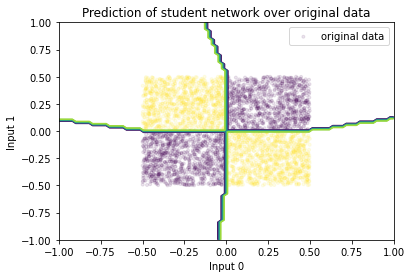

In [11]:
y_pred = student.predict(inputs)

X = np.linspace(-1,1,100)
Y = X.copy()
xx,yy = np.meshgrid(X,Y)
labels = student.predict(np.c_[xx.ravel(), yy.ravel()])
labels = np.argmax(labels, axis=1)
z = labels.reshape(xx.shape)

plt.contour(xx,yy,z, label="Prediction (large)")
plt.scatter(inputs[:,0], inputs[:,1], c=outputs[:,0], marker=".", label="original data", alpha=0.1)
plt.legend()
plt.title("Prediction of student network over original data")
plt.xlabel("Input 0")
plt.ylabel("Input 1")
plt.show()

# Verify both networks

Assert that the decision is correct inside quadrant 1 with 0.2 padding to axis.



## NNenum

To verify using nnenum, we first write out the networks to a location on disk. Then, we use tf2onnx to convert these networks to the onnx file format. Then, we generate the property file in the vnnlib file format. Finally, we use Docker to run nnenum, computing the verification.

In [12]:
tf.saved_model.save(student, "../../output_data/xor_example/student_model")
tf.saved_model.save(teacher, "../../output_data/xor_example/teacher_model")

INFO:tensorflow:Assets written to: ../../output_data/xor_example/student_model/assets
INFO:tensorflow:Assets written to: ../../output_data/xor_example/teacher_model/assets


In [13]:
!python -m tf2onnx.convert --saved-model ../../output_data/xor_example/student_model --output ../../output_data/xor_example/student_model.onnx --opset 11
!python -m tf2onnx.convert --saved-model ../../output_data/xor_example/teacher_model --output ../../output_data/xor_example/teacher_model.onnx --opset 11

/Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/runpy.py:127: RuntimeWarning: 'tf2onnx.convert' found in sys.modules after import of package 'tf2onnx', but prior to execution of 'tf2onnx.convert'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
2022-11-04 22:37:48,447 - WARNING - '--tag' not specified for saved_model. Using --tag serve
2022-11-04 22:37:48,634 - INFO - Signatures found in model: [serving_default].
2022-11-04 22:37:48,634 - WARNING - '--signature_def' not specified, using first signature: serving_default
2022-11-04 22:37:48,635 - INFO - Output names: ['dense_9']
Instructions for updating:
Use `tf.compat.v1.graph_util.extract_sub_graph`
2022-11-04 22:37:48,673 - WARNING - From /Users/jperrsau/opt/anaconda3/envs/distill-env/lib/python3.9/site-packages/tf2onnx/tf_loader.py:711: extract_sub_graph (from tensorflow.python.framework.graph_util_impl) is deprecated and will be removed in a future version.
Instructions for updating:
Use `tf.comp

In [14]:
property = """
; Quadrant 1 Property

(declare-const X_0 Real)
(declare-const X_1 Real)

(declare-const Y_0 Real)
(declare-const Y_1 Real)

; If we are in quadrant 1
(assert (>= X_0 0.2))
(assert (<= X_0 1.0))
(assert (>= X_1 0.2))
(assert (<= X_1 1.0))

; Probability of output 1 should be higher than output 0
(assert (>= Y_1 Y_0))
"""

with open("../../output_data/xor_example/property.vnnlib", "w") as file:
    file.write(property)


In [15]:
!docker run -it -v /Users/jperrsau/cu-src/thesis/src/distill/output_data/xor_example:/xor_example nnenum_image bash -c "python3 -m nnenum.nnenum /xor_example/student_model.onnx /xor_example/property.vnnlib > /xor_example/verify_student.stdout"

In [16]:
!docker run -it -v /Users/jperrsau/cu-src/thesis/src/distill/output_data/xor_example:/xor_example nnenum_image bash -c "python3 -m nnenum.nnenum /xor_example/teacher_model.onnx /xor_example/property.vnnlib > /xor_example/verify_teacher.stdout"

In [17]:
!cat ../../output_data/xor_example/verify_teacher.stdout

all input names: ['dense_input', 'StatefulPartitionedCall/sequential/dense/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/MatMul:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense/Relu:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/MatMul:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_1/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_1/Relu:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/MatMul:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential/dense_2/BiasAdd:0', 'StatefulPartitionedCall/sequential/dense_2/Relu:0', 'StatefulPartitionedCall/sequential/dense_3/MatMul/ReadVariabl

In [18]:
!cat ../../output_data/xor_example/verify_student.stdout

all input names: ['dense_7_input', 'StatefulPartitionedCall/sequential_1/dense_7/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_1/dense_7/MatMul:0', 'StatefulPartitionedCall/sequential_1/dense_7/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_1/dense_7/BiasAdd:0', 'StatefulPartitionedCall/sequential_1/dense_7/Relu:0', 'StatefulPartitionedCall/sequential_1/dense_8/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_1/dense_8/MatMul:0', 'StatefulPartitionedCall/sequential_1/dense_8/BiasAdd/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_1/dense_8/BiasAdd:0', 'StatefulPartitionedCall/sequential_1/dense_8/Relu:0', 'StatefulPartitionedCall/sequential_1/dense_9/MatMul/ReadVariableOp:0', 'StatefulPartitionedCall/sequential_1/dense_9/MatMul:0', 'StatefulPartitionedCall/sequential_1/dense_9/BiasAdd/ReadVariableOp:0']
Running in parallel with 6 processes
(0.0 sec) Q: 0, Sets: 0/1  (0.0%) ETA: - (expected 1 stars)   



Total Stars: 3 (1 exact, 2 app